# Setup

Imports

In [2]:
import os
import cv2
import time
import uuid
import json
import shutil
import numpy as np
import splitfolders
import tensorflow as tf
import albumentations as alb
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D

Collect images

In [3]:
# # Using opencv library to take the pics
# # Using the uuid library to generate unique ids to every pic

# cap = cv2.VideoCapture(0)
# for img_num in range(30):
#     print(f'collecting image {img_num}')
#     ret, frame = cap.read()
#     img_name = f'data/images/{str(uuid.uuid1())}.jpg'
#     cv2.imwrite(img_name, frame)
#     cv2.imshow('frame', frame)
#     time.sleep(1)

#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

Manually label the images with labelme

In [4]:
# # Launches the labelme app, in which the labeling is done manually
# !labelme

# Image review and loading

Since i am training the model on my mac, I have downloaded the apple tensorflow fork which utilizes the M2 chip GPU.

Load image to tf pipeline

In [5]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-01 15:27:36.863158: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-01 15:27:36.863190: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def load_image(path):
    """
    converts the image path to a tensor of the image
    path: the path of the image
    returns: tensor uint8
    """
    byte_img = tf.io.read_file(path) # image in bytes
    img = tf.io.decode_jpeg(byte_img) # image as tensor uint8
    return img

images = images.map(load_image)
# creating iterator of batches
img_gen = images.batch(4).as_numpy_iterator() 

2023-03-01 15:27:36.930541: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Visualize the images with matplotlib

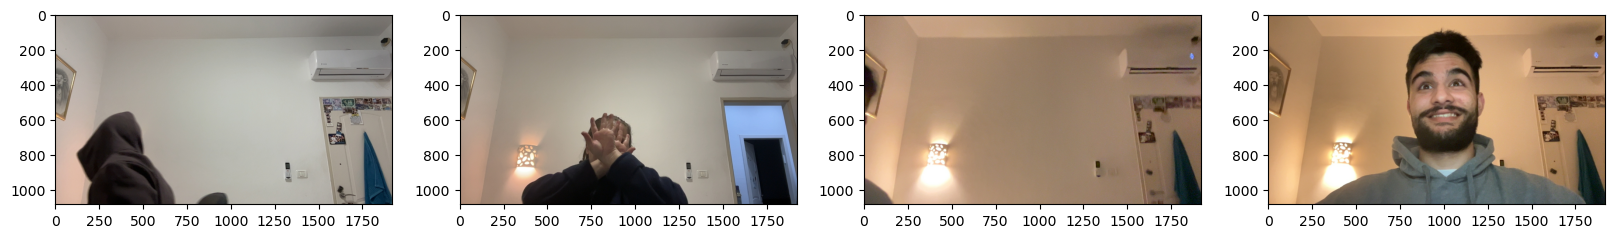

In [7]:
# plotting a batch
plot_imgs = img_gen.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, image in enumerate(plot_imgs):
    ax[i].imshow(image)
plt.show()

# Data partition

In [8]:
# I am using the splitfolders package which makes the train-val-test on jpg files much easier

# creating a directories in the format needed for the splitfolders library
if not os.path.exists("lab_data"): os.mkdir("lab_data")
if not os.path.exists("lab_data/face"): os.mkdir("lab_data/face")
if not os.path.exists("lab_data/noface"): os.mkdir("lab_data/noface")

# separating the images by their classes
for img_name in os.listdir("data/images/"):
    src = f"data/images/{img_name}"
    dst = f"lab_data/noface/"
    # if the json file of the image exists in the labels dir -> there is a face in the image
    if os.path.exists(f"data/labels/{img_name[:-4]}.json"):
        dst = f"lab_data/face/"
    shutil.copy(src, dst)

In [9]:
# splitting the data (train - 70%, val - 10%, test - 20%)
splitfolders.ratio("lab_data", output="split_data", seed=42, ratio=(.7, .1, .2))

Copying files: 175 files [00:00, 3901.82 files/s]


In [10]:
# grouping the data again fot better tf compatibility
for split_dir in ["split_data/train", "split_data/val", "split_data/test"]:
    if not os.path.exists(f"{split_dir}/images"): os.mkdir(f"{split_dir}/images")
    if not os.path.exists(f"{split_dir}/labels"): os.mkdir(f"{split_dir}/labels")
    
    for img_name in list(filter(lambda x: "jpg" in x, os.listdir(f"{split_dir}/face"))):
        # transferring the json files in tf format
        json_src = f"data/labels/{img_name[:-4]}.json" 
        json_dst = f"{split_dir}/labels/"
        shutil.copy(json_src, json_dst)
        # transferring the jpg files in tf format
        jpg_src = f"{split_dir}/face/{img_name}"
        jpg_dst = f"{split_dir}/images"
        shutil.move(jpg_src, jpg_dst)
    
    for img_name in list(filter(lambda x: "jpg" in x, os.listdir(f"{split_dir}/noface"))):
        # transferring the jpg files in tf format
        jpg_src = f"{split_dir}/noface/{img_name}"
        jpg_dst = f"{split_dir}/images"
        shutil.move(jpg_src, jpg_dst)

    # removing the dirs used to split the folders
    os.rmdir(f"{split_dir}/face")
    os.rmdir(f"{split_dir}/noface")

# Image Augmentation

Creating the augmentation pipeline

In [11]:
augmenter = alb.Compose([alb.RandomCrop(width=1000, height=1000),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',
                                                    label_fields=['class_labels']))

Get coordiantes and rescale to match image res

In [12]:
def fix_coords(c):
    """
    for some coords, the x/y labels are not in the correct order, so i will check and fix that
    """
    if c[0] > c[2]:
        c[[0,2]] = c[[2,0]]
    if c[1] > c[3]:
        c[[1,3]] = c[[3,1]]
    return c

Build and run the pipeline on all of the images

In [13]:
# creating the needed folders for the augmentation part
if not os.path.exists("aug_data"): os.mkdir("aug_data")
for split in ["train", "val", "test"]:
    if not os.path.exists(f"aug_data/{split}"): os.mkdir(f"aug_data/{split}")
    if not os.path.exists(f"aug_data/{split}/images"): os.mkdir(f"aug_data/{split}/images")
    if not os.path.exists(f"aug_data/{split}/labels"): os.mkdir(f"aug_data/{split}/labels")

In [14]:
for split in ['train', 'val', 'test']:
    for img_name in os.listdir(f"split_data/{split}/images"):

        img = cv2.imread(f"split_data/{split}/images/{img_name}")
        coords = [0, 0, 0.00001, 0.00001]
        lab_path = f"split_data/{split}/labels/{img_name[:-4]}.json"
        if os.path.exists(lab_path):
            with open(lab_path, 'r') as f:
                label = json.load(f)
                
            coords = fix_coords(np.array(label['shapes'][0]['points'])
                                .reshape(1, 4)[0] / ([1920, 1080] * 2))
            
        try:
            for i in range(30):
                augmented = augmenter(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(f"aug_data/{split}/images/{img_name[:-4]}.{i}.jpg", augmented["image"])

                annotation = {}
                annotation["image"] = img_name
                
                if os.path.exists(lab_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(f"aug_data/{split}/labels/{img_name[:-4]}.{i}.json", 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Load augmented data to tf dataset

In [15]:
img_dict = {}
for split in ['train', 'val', 'test']:
    img_dict[split] = tf.data.Dataset.list_files(f'aug_data/{split}/images/*.jpg', shuffle=False)
    img_dict[split] = img_dict[split].map(load_image)
    img_dict[split] = img_dict[split].map(lambda x: tf.image.resize(x, (120,120)))
    img_dict[split] = img_dict[split].map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Prepare labels

Build label loading function

In [16]:
def load_labels(label_path):
    """
    gets the label path and load the json
    returns tuple of class (object/ no object), and bounding box coordinates
    """
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [17]:
lab_dict = {}
for split in ['train', 'val', 'test']:
    lab_dict[split] = tf.data.Dataset.list_files(f'aug_data/{split}/labels/*.json', shuffle=False)
    lab_dict[split] = lab_dict[split].map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# Label & image combination

In [18]:
for split in ['train', 'val', 'test']:
    print(f'{split} images length: {len(img_dict[split])}')
    print(f'{split} labels length: {len(lab_dict[split])}')

train images length: 3660
train labels length: 3660
val images length: 510
val labels length: 510
test images length: 1080
test labels length: 1080


Creating the whole dataset (train, test, val) with labels

In [19]:
data = {}
for split in ['train', 'val', 'test']:
    data[split] = tf.data.Dataset.zip((img_dict[split], lab_dict[split]))
    data[split] = data[split].shuffle(int(len(img_dict[split])*1.1))
    # creating batches of 8 for the model
    data[split] = data[split].batch(8)
    data[split] = data[split].prefetch(4)

Testing if the image and label are fitting 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


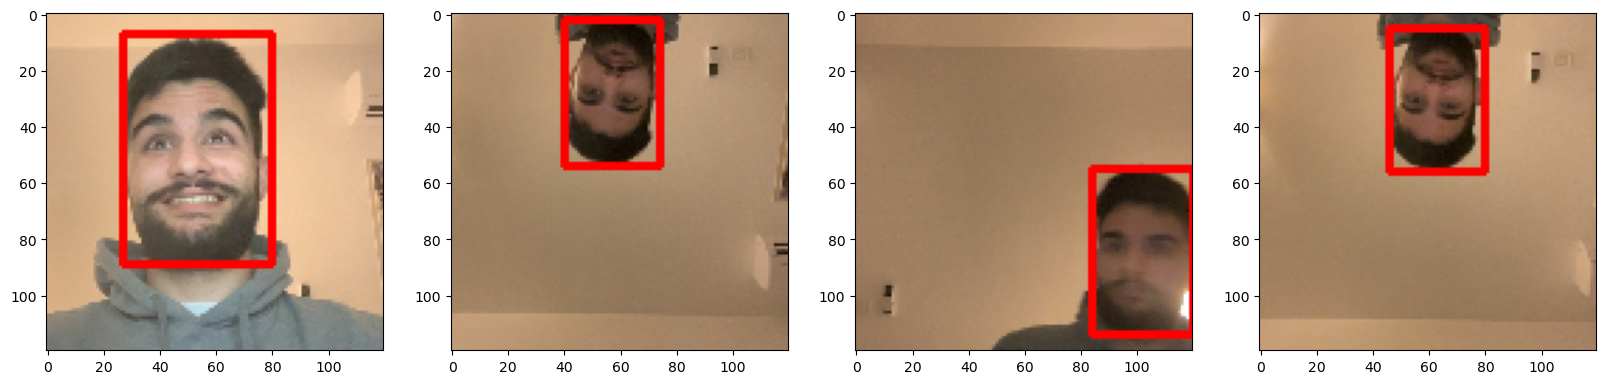

In [20]:
data_samples = data['train'].as_numpy_iterator()
res = data_samples.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# DL model

In [21]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)

    # classification model
    f1 = GlobalMaxPooling2D()(vgg)
    cls1 = Dense(2048, activation='relu')(f1)
    cls2 = Dense(1, activation='sigmoid')(cls1)

    # bbox model
    f2 = GlobalMaxPooling2D()(vgg)
    reg1 = Dense(2048, activation='relu')(f2)
    reg2 = Dense(4, activation='sigmoid')(reg1)

    face_tracker = Model(inputs=input_layer, outputs=[cls2, reg2])
    return face_tracker

In [22]:
face_tracker = build_model()
face_tracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_1[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

# Define losses and optimizers

In [23]:
batches_per_epoch = len(data['train'])
lr_decay = (1/0.75 -1) / batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)


In [24]:
def loc_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_pred[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_pred[:,3] - y_pred[:,1]
    w_pred = y_pred[:,2] - y_pred[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [25]:
cls_loss = tf.keras.losses.BinaryCrossentropy()
reg_loss = loc_loss

# Train neural network

In [26]:
class FaceTracker(Model):
    def __init__(self, face_tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = face_tracker

    def compile(self, opt, cls_loss, loc_loss, **kwargs):
        super().compile(**kwargs)
        self.cls_loss = cls_loss
        self.loc_loss = loc_loss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        
        X, y_true = batch

        with tf.GradientTape() as tape:
            # predicting the bbox
            y_pred = self.model(X, training=True)

            batch_cls_loss = self.cls_loss(y_true[0], y_pred[0])
            batch_loc_loss = self.loc_loss(tf.cast(y_true[1], tf.float32), y_pred[1])

            # weighted avg of the two losses from above
            total_loss = batch_loc_loss + 0.5 * batch_cls_loss

            # calculating the gradient
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        # moving the the gradient opposite direction
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        # logging the losses
        return {"total loss": total_loss, "class loss": batch_cls_loss, "regression loss": batch_loc_loss}
    
    def test_step(self, batch, **kwargs):
        X, y_true = batch

        y_pred = self.model(X, training=True)

        batch_cls_loss = self.cls_loss(y_true[0], y_pred[0])
        batch_loc_loss = self.loc_loss(tf.cast(y_true[1], tf.float32), y_pred[1])
        total_loss = batch_loc_loss + 0.5 * batch_cls_loss

        return {"total loss": total_loss, "class loss": batch_cls_loss, "regression loss": batch_loc_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [27]:
model = FaceTracker(face_tracker)
model.compile(opt, cls_loss, reg_loss)

Training the model

In [28]:
hist = model.fit(data['train'], epochs=30, validation_data=data['val'])

Epoch 1/30


2023-03-01 15:28:09.219412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


458/458 [==============================] - ETA: 0s - total loss: 0.5906 - class loss: 0.1993 - regression loss: 0.4910

2023-03-01 15:29:15.537176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


458/458 [==============================] - 70s 137ms/step - total loss: 0.5894 - class loss: 0.1988 - regression loss: 0.4900 - val_total loss: 0.1832 - val_class loss: 0.0732 - val_regression loss: 0.1466
Epoch 2/30
458/458 [==============================] - 72s 142ms/step - total loss: 0.1958 - class loss: 0.0765 - regression loss: 0.1576 - val_total loss: 0.1272 - val_class loss: 0.0057 - val_regression loss: 0.1243
Epoch 3/30
458/458 [==============================] - 73s 140ms/step - total loss: 0.1451 - class loss: 0.0571 - regression loss: 0.1165 - val_total loss: 0.2055 - val_class loss: 0.0524 - val_regression loss: 0.1793
Epoch 4/30
458/458 [==============================] - 68s 134ms/step - total loss: 0.0863 - class loss: 0.0315 - regression loss: 0.0706 - val_total loss: 0.1010 - val_class loss: 0.0107 - val_regression loss: 0.0957
Epoch 5/30
458/458 [==============================] - 68s 134ms/step - total loss: 0.0576 - class loss: 0.0207 - regression loss: 0.0473 - val_

In [29]:
hist.history

{'total loss': [0.028067609295248985,
  0.05955591797828674,
  0.3681586980819702,
  0.014406007714569569,
  0.00994427502155304,
  0.0046981037594377995,
  0.12997207045555115,
  0.004024484660476446,
  0.0036394663620740175,
  0.009259971790015697,
  0.0019454974681138992,
  0.0036117893178015947,
  0.003116884268820286,
  0.0025067483074963093,
  0.001973868813365698,
  0.005169698968529701,
  0.0006733142654411495,
  0.001959658693522215,
  0.004710918292403221,
  0.0016073836013674736,
  0.001412498764693737,
  0.0015294167678803205,
  0.0003430129145272076,
  0.0012368526076897979,
  0.00019672316557262093,
  0.0036139776930212975,
  0.0008118337136693299,
  0.0015555642312392592,
  0.001372946542687714,
  0.001032019965350628],
 'class loss': [0.001904012868180871,
  0.0009724468691274524,
  0.3589867353439331,
  0.00197168649174273,
  0.00015276145131792873,
  0.0014827052364125848,
  0.14614036679267883,
  0.001806675223633647,
  0.0002527225879020989,
  0.00017529867182020098

Plotting the train loss vs the validation loss

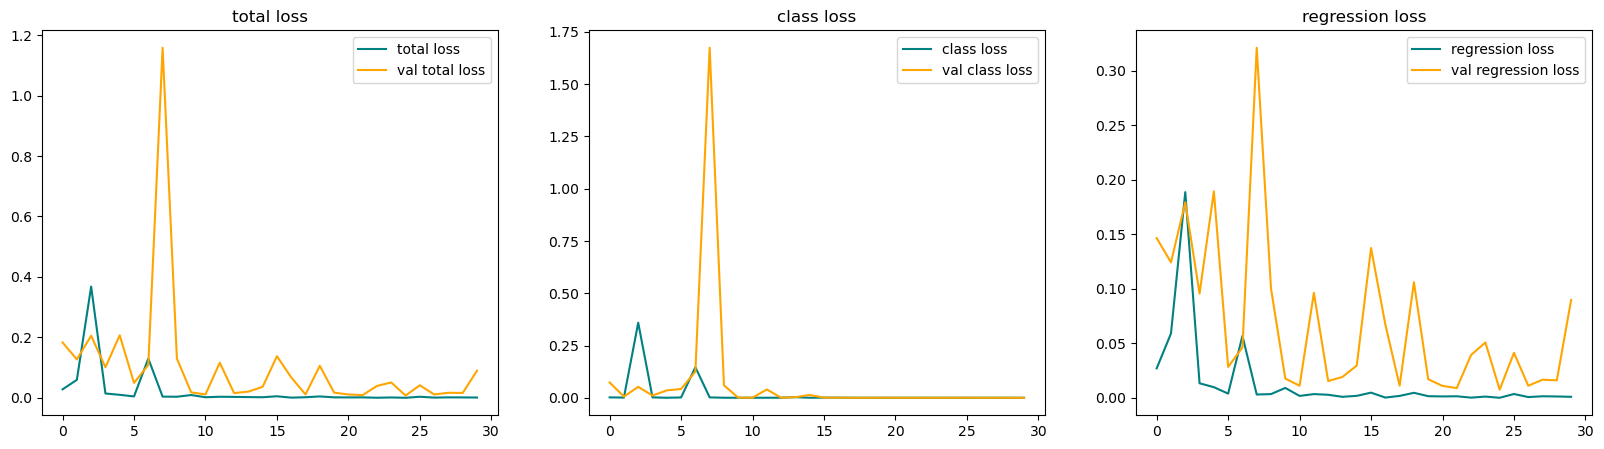

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

for i, loss in enumerate(['total loss', 'class loss', 'regression loss']):
    ax[i].plot(hist.history[loss], color='teal', label = loss)
    ax[i].plot(hist.history['val_'+loss], color='orange', label = 'val ' + loss)
    ax[i].title.set_text(loss)
    ax[i].legend()



# Prediction

In [31]:
test_data = data['test'].as_numpy_iterator()
test_sample = test_data.next()
y_pred = face_tracker.predict(test_sample[0])

1/1 [==============================] - 0s 261ms/step


2023-03-01 16:02:41.468432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


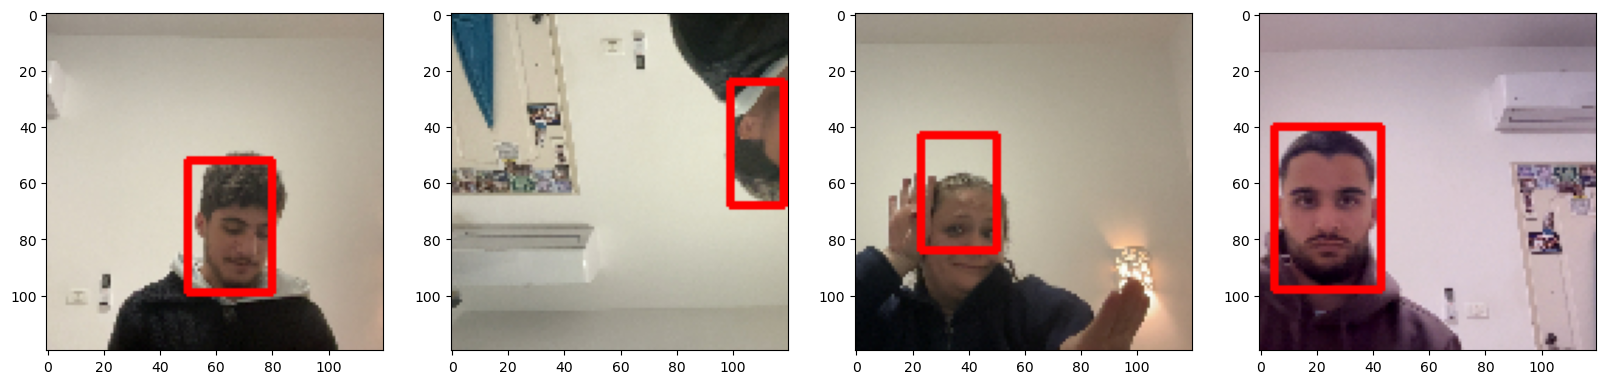

In [32]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = y_pred[1][idx]
    
    if y_pred[0][idx] > 0.9: # if the model predicts a face
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# Model saving

In [33]:
face_tracker.save('face_tracker.h5')